In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from pypfopt import expected_returns, risk_models
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from statsmodels.stats.stattools import durbin_watson, jarque_bera
import scipy.optimize as sco

In [3]:
tickers = ['AAPL', 'BAC', 'INTC', 'GME', 'BA', 'BABA', 'UA', 'KO', 'NVDA', 'META']
data = yf.download(tickers= tickers, start='2018-01-01', end ='2021-01-01', group_by='ticker', threads= True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


<Axes: xlabel='Date'>

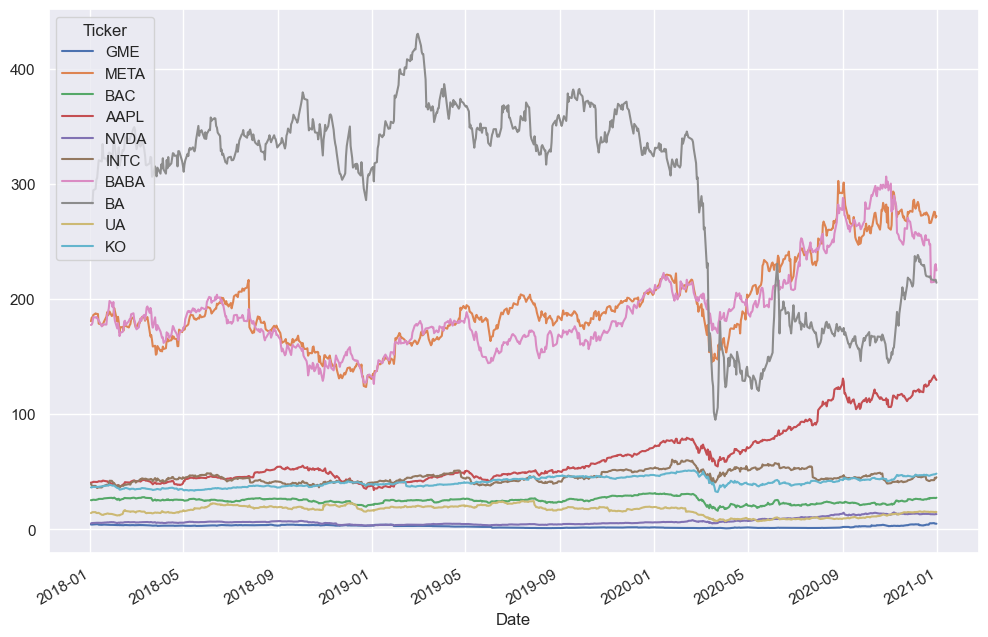

In [4]:
close_prices = data.xs('Close', axis=1, level=1)
close_prices.plot(kind="line", figsize=(12, 8))

<Axes: xlabel='Date'>

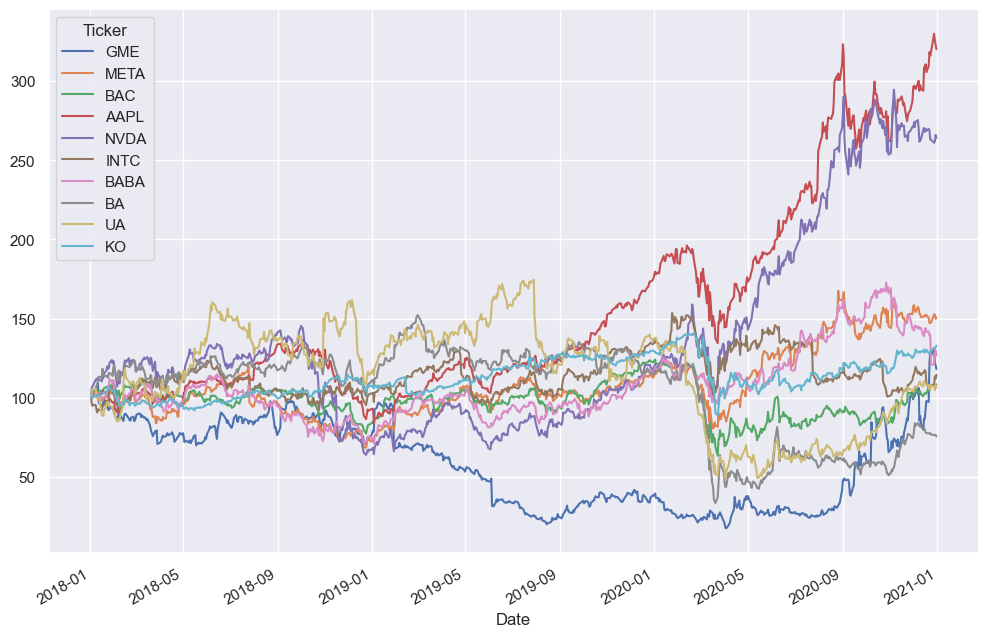

In [5]:
normalize_prices = close_prices.div(close_prices.iloc[0]).mul(100)
normalize_prices.plot(kind='line', figsize=(12, 8))

In [6]:
simple_returns = close_prices.pct_change().dropna()

In [7]:
daily_returns = simple_returns.mean()
daily_risk = simple_returns.std()
covariance = simple_returns.cov()*252

In [8]:
yearly_returns = daily_returns.apply(lambda x : ((x + 1)**252) -1)
yearly_risks = daily_risk.apply(lambda x : x * np.sqrt(252))

## Working with the library PyPortfolioOpt

In [9]:
mu = expected_returns.mean_historical_return(close_prices, compounding = False)
S = risk_models.CovarianceShrinkage(close_prices).ledoit_wolf()

target_returns = np.linspace(mu.min(), mu.max(), 200)
volatilities = []
returns_list = []

for target_return in target_returns:
    ef_temp = EfficientFrontier(mu, S)
    try:
        ef_temp.efficient_return(target_return)
        performance = ef_temp.portfolio_performance()
        ret, vol, sr = performance
        returns_list.append(ret)
        volatilities.append(vol)
    except Exception as e:
        returns_list.append(np.nan)
        volatilities.append(np.nan)

ef_max = EfficientFrontier(mu,S)
weights_max = ef_max.max_sharpe()
ret_max, vol_max, sr_max = ef_max.portfolio_performance()

ef_min = EfficientFrontier(mu, S)
weights_min = ef_min.min_volatility()
ret_min, vol_min, sr_min = ef_min.portfolio_performance()

In [ ]:
cov_matrix = covariance.to_numpy()
exp_returns = yearly_returns.to_numpy()

n_portfolios = 250000
results = np.zeros((3, n_portfolios))
weights_record = []

for i in range(n_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)

    port_return = np.dot(weights, exp_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    results[0, i] = port_std
    results[1, i] = port_return
    # Compute Sharp Ratio with a free risk iquals zero
    results[2, i] = (port_return) / port_std

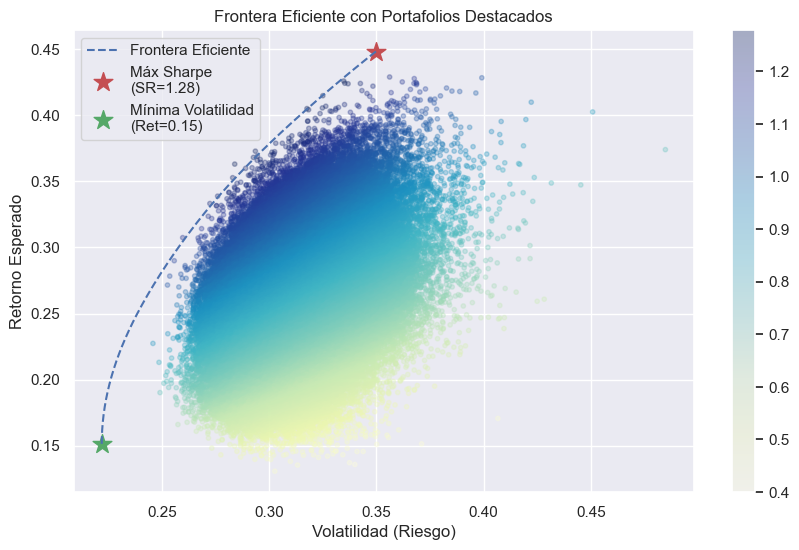

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar()

plt.plot(volatilities, returns_list, "b--", label="Frontera Eficiente")
plt.scatter(vol_max, ret_max, marker="*", color="r", s=200, label=f"Máx Sharpe\n(SR={sr_max:.2f})")
plt.scatter(vol_min, ret_min, marker="*", color="g", s=200, label=f"Mínima Volatilidad\n(Ret={ret_min:.2f})")
plt.xlabel("Volatilidad (Riesgo)")
plt.ylabel("Retorno Esperado")
plt.title("Frontera Eficiente con Portafolios Destacados")
plt.legend()
plt.grid(True)
plt.show()